# Data wrangling at the movies with Nate, Alejandra, Andrew, and Krystal 🍿

### What can we learn by gathering, cleaning, sorting, and filtering available movie data?

# Part I: Setup and data cleaning

![title](https://pbs.twimg.com/media/ESSJfMvXYAADDZb.jpg)

"Rain Man", 1987

In [55]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from numpy import NaN
import pandas as pd
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Turning off a warning for now..
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Import movies (IMDB)
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings (IMDB)
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew (IMDB)
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics (IMDB)
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data (BoxOfficeMojo)
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data (https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films)
oscars = pd.read_csv('../data/oscars_cleaned.csv')

In [3]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [4]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [5]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

In [6]:
# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

# Drop, rename, change \N to NaN
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})
combined = combined.replace(r'\\N','NaN', regex=True)
combined = combined[combined['Runtime (min)']!='NaN']
combined = combined[combined['Genre (main)']!='NaN']

# Convert NaN to 0 for Awards and Nominiations
combined['Awards']=combined['Awards'].fillna(0)
combined['Nominations']=combined['Nominations'].fillna(0)

In [7]:
## Drop items we don't have data for (i.e. Studio or Gross (lifetime) data)
dropped = combined.dropna(axis='rows')
#print(dropped.dtypes)

In [8]:
dropped['Year'] = dropped['Year'].astype(float)
dropped['Runtime (min)'] = dropped['Runtime (min)'].astype(float)
dropped['Votes'] = dropped['Votes'].astype(int)
dropped['Awards'] = dropped['Awards'].astype(int)
dropped['Nominations'] = dropped['Nominations'].astype(int)
dropped['Gross (lifetime)'] = dropped['Gross (lifetime)'].astype(float)

In [9]:
# List out genres
genre_list = dropped['Genre (main)'].unique()
genre_list

array(['Biography', 'Drama', 'Western', 'Action', 'Mystery', 'Comedy',
       'Adventure', 'Horror', 'Fantasy', 'Romance', 'Documentary',
       'Crime', 'Musical', 'Sci-Fi', 'Animation', 'Film-Noir', 'Family',
       'Thriller', 'Music', 'History', 'War', 'Sport'], dtype=object)

In [10]:
## Code genres numerically
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Action',1, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Adventure',2, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Biography',3, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Comedy',4, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Crime',5, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Drama',6, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Family',7, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Fantasy',8, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Film-Noir',9, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'History',10, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Horror',11, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Musical',12, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Mystery',13, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Romance',14, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sci-Fi',15, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sport',16, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Thriller',17, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'War',18, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Western',19, regex=True)

### Data from IMDB, Box Office Mojo, Wikipedia (Oscar wins and nominations). Joined, cleaned, filtered. Coded genres as numbers.
### Data and notebooks running locally

In [11]:
# Drop studios
dropped = dropped.drop(['Studio'], axis=1)

# Drop Animation, Documentary, Music genres (did not code above, so use text)
dropped = dropped[dropped['Genre (main)']!='Animation']
dropped = dropped[dropped['Genre (main)']!='Documentary']
dropped = dropped[dropped['Genre (main)']!='Music']

#print(dropped.dtypes)

dropped.head()
#dropped['Genre (main)'].value_counts()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Gross (lifetime),Awards,Nominations
184,Passion,1919.0,85.0,3,6.8,732,92181.0,0,0
249,The Count of Monte Cristo,1913.0,69.0,6,5.6,37,54234062.0,0,0
519,The Escape,1914.0,60.0,6,5.9,15,12074.0,0,0
604,Jane Eyre,1914.0,50.0,6,6.6,7,11242660.0,0,0
937,The Birth of a Nation,1915.0,195.0,6,6.4,21494,15861566.0,0,0


In [12]:
dropped.count()

Title               17779
Year                17778
Runtime (min)       17779
Genre (main)        17779
Rating (avg.)       17779
Votes               17779
Gross (lifetime)    17779
Awards              17779
Nominations         17779
dtype: int64

# Part II: Analysis in two dimensions

![title](https://si.wsj.net/public/resources/images/LE-AA142_MOVIES_G_20110922152847.jpg)


"Sneakers", 1992

In [13]:
# Reset index to avoid sklearn problems
dropped = dropped.reset_index()
dropped = dropped.drop(['index'], axis=1)

###  🎞️ All movies: Votes by Average rating

Text(0, 0.5, 'Votes')

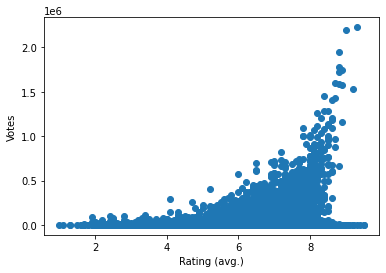

In [14]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

### 🎞️ All movies: Average rating by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Rating (avg.)')

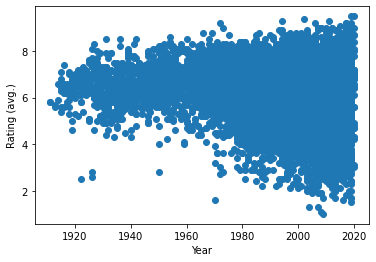

In [15]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Rating (avg.)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Rating (avg.)')

### 🎞️ All movies: Lifetime gross by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Gross (lifetime)')

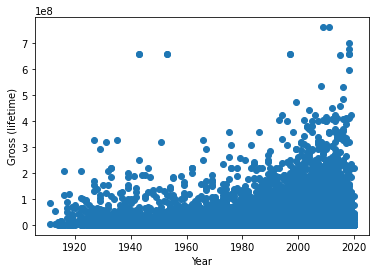

In [16]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Gross (lifetime)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Gross (lifetime)')

### 🎞️ All movies: Oscar nominations by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Nominations')

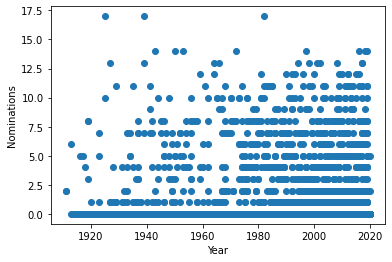

In [17]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Nominations'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Nominations')

### 🎞️ All movies: Oscar wins by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Awards')

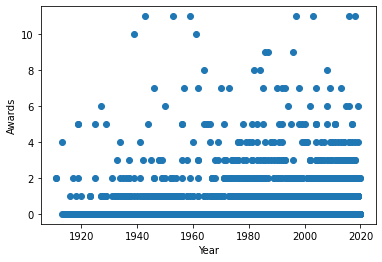

In [18]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Awards'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Awards')

In [19]:
# Filter to one genre (Drama)
drama = dropped[dropped['Genre (main)']==6]

# Reset index to avoid sklearn problems
drama = drama.reset_index()
drama = drama.drop(['index'], axis=1)

drama.count()

Title               5669
Year                5668
Runtime (min)       5669
Genre (main)        5669
Rating (avg.)       5669
Votes               5669
Gross (lifetime)    5669
Awards              5669
Nominations         5669
dtype: int64

### 🎭 Drama: Votes by Average rating

Text(0, 0.5, 'Votes')

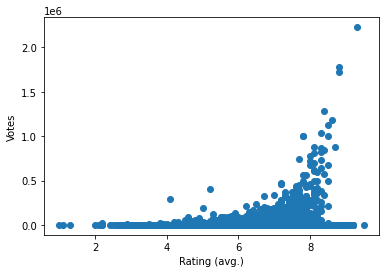

In [20]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Rating (avg.)'].values.reshape(-1, 1)
y = drama['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

### 🎭 Drama: Average rating by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Rating (avg.)')

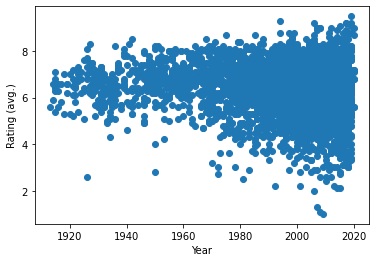

In [21]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Rating (avg.)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Rating (avg.)')

### 🎭 Drama: Lifetime gross by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Gross (lifetime)')

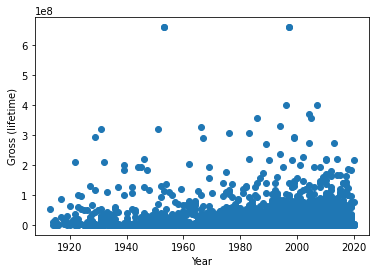

In [22]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Gross (lifetime)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Gross (lifetime)')

### 🎭 Drama: Oscar nominations by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Nominations')

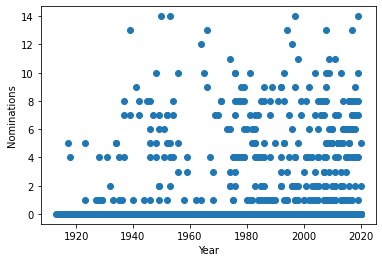

In [23]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Nominations'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Nominations')

### 🎭 Drama: Oscar wins by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Awards')

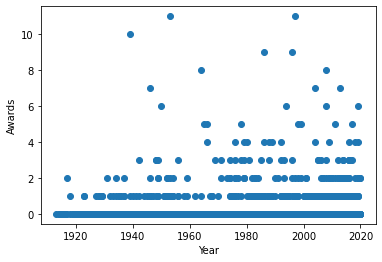

In [24]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Awards'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Awards')

## Part III: Analysis in three dimensions

![title](https://geekandsundry.com/wp-content/uploads/2018/05/star-trek-3D-chess-1024x537.jpg)
"Star Trek", 1967

### Lifetime gross vs. length vs. year

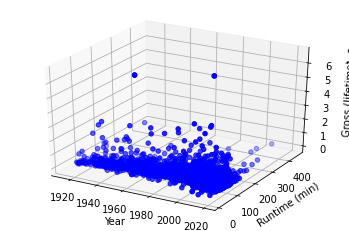

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = drama['Year']
y = drama['Runtime (min)']
z = drama['Gross (lifetime)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Year')
ax.set_ylabel('Runtime (min)')
ax.set_zlabel('Gross (lifetime)')
plt.show()

### Average rating vs. length vs. year

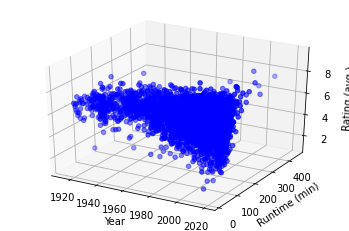

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = drama['Year']
y = drama['Runtime (min)']
z = drama['Rating (avg.)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Year')
ax.set_ylabel('Runtime (min)')
ax.set_zlabel('Rating (avg.)')
plt.show()

### Average rating vs. genre vs. year

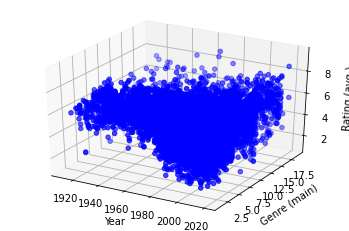

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dropped['Year']
y = dropped['Genre (main)']
z = dropped['Rating (avg.)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Year')
ax.set_ylabel('Genre (main)')
ax.set_zlabel('Rating (avg.)')
plt.show()

# Part IV: Machine Learning: Two dimensions

![title](https://s3.amazonaws.com/images.wealthyaffiliate.com/uploads/1222607/sitecontent/b3e5656b9f26cdde2faf5c5524db9530_cropped_1512609988.jpg?1512609988)

"Tron", 1982

## Question: _How well can we predict how many votes a drama would have with a given average user rating?_

### Step 1: Training

In [72]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Rating (avg.)'].values.reshape(-1, 1)
y = drama['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# Drop NaN
X = X[np.logical_not(np.isnan(X))]
y = y[np.logical_not(np.isnan(y))]

In [33]:
# Create model
model = LinearRegression()

# Fit model to training data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Step 2: Calculate Mean Squared Error and R-squared for testing data

In [34]:
# Calculate mean_squared_error and r-squared value for testing data

# Use model to make predictions
predicted = model.predict(X_test)

# Score predictions
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 8162752957.356545
R-squared (R2): 0.048029341797336755


### Step 3: Compare testing and training data, plot residuals

In [36]:
# Score and print scores
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training score: {training_score}")
print(f"Testing score: {testing_score}")

Training score: 0.059556483037829906
Testing score: 0.048029341797336755


Text(0.5, 1.0, 'Residual plot')

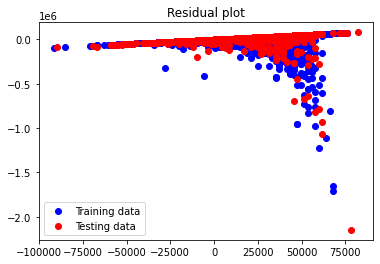

In [37]:
# Plot residuals
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="red", label="Testing data")
plt.legend()
#plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual plot")

### Verdict: *We can predict with a small degree of confidence, though it may not be the case that the data has a linear relationship.*

## Revised question: How well can we predict how many Oscars a drama would win given average user rating?

### Step 1: Training

In [73]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Awards'].values.reshape(-1, 1)
y = drama['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

In [39]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Drop NaN
X = X[np.logical_not(np.isnan(X))]
y = y[np.logical_not(np.isnan(y))]

In [40]:
# Create model
model = LinearRegression()

# Fit model to training data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Step 2: Calculate Mean Squared Error and R-squared for testing data

In [41]:
# Calculate mean_squared_error and r-squared value for testing data

# Use model to make predictions
predicted = model.predict(X_test)

# Score predictions
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 8726471838.904385
R-squared (R2): -0.017713654163936887


### Step 3: Compare testing and training data, plot residuals

In [43]:
# Score and print scores
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training score: {training_score}")
print(f"Testing score: {testing_score}")

Training score: 0.1480204399344618
Testing score: -0.017713654163936887


Text(0.5, 1.0, 'Residual plot')

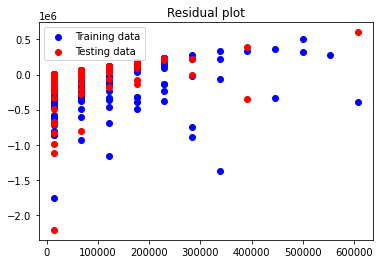

In [44]:
# Plot residuals
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="red", label="Testing data")
plt.legend()
#plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual plot")

### Verdict: *Negative R-squared value – doing worse than the mean value. The features we used may not have had a high enough correlation to the values we were trying to predict.*

# Part V: Machine Learning: 3+ dimensions

![title](https://i.imgflip.com/tiiak.jpg?a440880)

"Spaceballs", 1987

In [45]:
# Reference: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

dropped.head()
#dropped.shape
#dropped.describe()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Gross (lifetime),Awards,Nominations
0,Passion,1919.0,85.0,3,6.8,732,92181.0,0,0
1,The Count of Monte Cristo,1913.0,69.0,6,5.6,37,54234062.0,0,0
2,The Escape,1914.0,60.0,6,5.9,15,12074.0,0,0
3,Jane Eyre,1914.0,50.0,6,6.6,7,11242660.0,0,0
4,The Birth of a Nation,1915.0,195.0,6,6.4,21494,15861566.0,0,0


## Question: Can movie length, genre, and average rating give us a good predication of the gross lifetime earnings?

In [81]:
X = dropped[['Runtime (min)', 'Genre (main)', 'Rating (avg.)']].values
y = dropped['Gross (lifetime)'].values

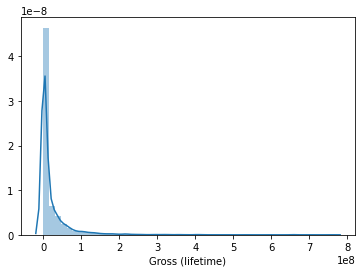

In [82]:
# Check average value of Gross (lifetime) column
plt.figure()
seabornInstance.distplot(dropped['Gross (lifetime)'])

In [83]:
# Split 80% of the data to the training set and 20% as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train model 
model = LinearRegression()

In [84]:
# Fit the model and score
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.037987452827632384


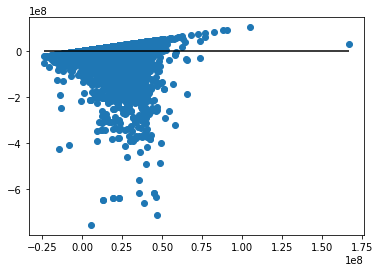

In [85]:
# Use residual plot to check predications (since difficult to plot line in 3D space)
predictions = model.predict(X)
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [86]:
# Do prediction on test data
y_pred = model.predict(X_test)

# Look at the differences 
differences = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
differences.head()

,Actual,Predicted
0,127426.0,2.020146e+07
1,23240020.0,2.718173e+07
2,33745.0,1.454992e+07
3,800365.0,1.163195e+07
4,1474249.0,-3.576498e+05


### Verdict: *We can predict with a small degree of confidence, though it may not be the case that the data has a linear relationship.*

## Thanks!

![title](https://i1.wp.com/www.thehollywoodoutsider.com/wp-content/uploads/thats-all-folks.png)

## Backlog – some things to tackle in the sequel...

Additional potential analyses
 - More on genres
 - Studio
 - Budget
 - MPAA rating
 - Country
 - Language
 - Average gross/movie
 - Text analysis on titles
 - How many movies have been produced over time
 - Other ideas from our [Google Doc](https://docs.google.com/document/d/1pfk1bdshXdZUMV4avyM2F_1vuYAKOpfbbWDTPSkfzHs/edit#heading=h.2whyqbytzxsa)

Refine/refactor
 - Duplicates (without losing important data)
 - Text preparation 
 - Interactive website (genres with charts)

More inspiring words:
 - _We live in a box of space and time. Movies are windows in its walls. They allow us to enter other minds, not simply in the sense of identifying with the characters, although that is an important part of it, but by seeing the world as another person sees it._ - Roger Ebert
